In [1]:
import networkx as nx
from scipy.linalg import expm, sinm, cosm
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import osmnx as ox
from sklearn.metrics import mean_squared_error
import random
import plotly.graph_objects as go
import itertools as it
from tqdm.notebook import tqdm
from ipywidgets import FloatProgress
import matplotlib

## Functions

In [2]:
def cosine_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =2 - 2*comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])
    return cd

def comm_angle(G, comm = None):
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)
    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    angle = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            angle[i][j] =np.degrees(np.arccos(comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])))
    return angle




def comm_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =np.sqrt(comm[i][i] + comm[j][j] - 2*comm[i][j])
    return cd

def comm_geo(G, cd = None, comm = None): # adds mean flow as attribute and returns a matrix
  G_simple = nx.Graph(G)
  if cd is None:
    if comm is None:
      comm = add_comm_attr(G_simple)
    cd = comm_distance(G_simple, comm)
  dfA = nx.to_pandas_adjacency(G)
  X = (dfA*cd)
  GX = nx.from_pandas_adjacency(X, nx.DiGraph)
  dfSP = nx.to_pandas_adjacency(G)
  j = dict()
  for i in list(G.edges):
    try:
      j[i[0], i[1]] =  nx.dijkstra_path_length(GX, i[1], i[0], weight = "weight")
    except:
      j[i[0], i[1]] = 0

  # teste = pd.DataFrame.from_dict(j, orient = "index")
  # for i in teste.columns:
  #   for j in teste.columns:
  #     if np.isnan(teste[i][j]):
  #       dfSP[i][j] = 0
  #     else:
  #       dfSP[i][j] = teste[i][j]
  # nx.set_node_attributes(G, values=(dfSP.mean()).to_dict(), name="mean_flow")
  return j, cd


def add_CCC(G, comm = None, cd = None): # returns a dict with a centrality
    if cd is None:
        cd = cosine_distance(G,comm)
    d = (1/cd.sum())
    nx.set_node_attributes(G, values=d.to_dict(), name="CCC")
    return d




def add_comm_attr(G): # matrix and mean comm as attr
    # G_simple = nx.Graph(G)
    nodelist = list(G)
    A = nx.to_numpy_array(G, nodelist)

    Aexp2 = expm(A)
    mapping = dict(zip(nodelist, range(len(nodelist))))

    c = {}
    d = {}
    for u in G:
        c[u] = {}
        for v in G:
            c[u][v] = float(Aexp2[mapping[u], mapping[v]])
        d[u] = np.mean(list(c[u].values()))

    nx.set_node_attributes(G, values=d, name="comm")
    return c

def plotting(G, value, pos = None):
    groups = nx.get_node_attributes(G,value).values()
    mapping = dict(zip(count(),sorted(groups)))

    nodes = G.nodes()
    colors = [mapping[n] for n in nodes]

    # drawing nodes and edges separately so we can capture collection for colobar
    if not pos:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(10,10))
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()


def graph_folium_bg(G, n_attribute = None, e_attribute = None, cmap = "hot", poly = None):
    nodes, edges = ox.graph_to_gdfs(G)
    if poly is not None:
        m = poly.explore()
        m = edges.explore(m=m, column = e_attribute, cmap = cmap, color = "black")
    else:
        m = edges.explore(column = e_attribute, cmap = cmap, color = "black")
    m = nodes.explore(m=m, column = n_attribute, cmap = cmap, color = "black")
    return m

def calculations(G):
    flow, X = comm_geo(G)
    nx.set_edge_attributes(G, flow, "Flow of returnal")
    bet = nx.edge_betweenness_centrality(G, normalized = False)
    nx.set_edge_attributes(G, bet, "Betweenness")

    j = dict()
    for i in list(G.edges):
        try:
            j[i[0], i[1]] =  nx.dijkstra_path_length(G, i[1], i[0])
        except:
            j[i[0], i[1]] = 0

    df = pd.DataFrame(flow.values(), columns = ["Cost"], index = G.edges())
    df["Betweenness"] = bet.values()
    df["SP_inverse"] = j.values()
    return df, X

seed = 555
nodes = 1000
percents = np.arange(0.1, 0.51, 0.1)
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# Small grid 1

In [30]:
edgelist = [[1, 2], 
[3, 4],
[4, 8],
[2, 3],
[8, 12],
[12, 16],
[14, 13],
[9, 5], 
[5, 1],
[6, 10],
[16, 15],
[15, 14],
# [10, 11],
[11, 7],
# [7, 6],
[12, 11],
[10, 9],
[13, 9],
[1, 5],
[5, 6],
[9, 10],
# [14, 10],
[10, 14],
[15, 11],
[8, 7],
# [3, 7],
[7, 3],
[2, 6],
]


G = nx.from_edgelist(edgelist, create_using = nx.DiGraph)
graph = nx.DiGraph()
graph.add_nodes_from(sorted(G.nodes(data=True)))
graph.add_edges_from(G.edges(data=True))

## Exhaustive test

In [31]:
# dfs_wcc = []
# all_wccs_exhaustive = []
# total_wccs = []
# dict_result = []
# max_wcc = 1
# ii=0

# for j in tqdm(percents, position=1):
#     for i in tqdm(it.combinations(list(graph.edges), int(graph.number_of_edges()*j)), position = 0):
#         H = nx.DiGraph.copy(graph)
#         H.remove_edges_from(i)
#         wccs = []
#         for k in nx.weakly_connected_components(H):
#             wccs.append(len(k))
#         size_wccs = (max(wccs)/graph.number_of_nodes())
#         if max_wcc >= size_wccs:
#             best_edges = i
#             max_wcc = size_wccs
#     dict_result.append({"Edges": best_edges, "Wcc size": max_wcc})
    
# sizes = []
# for i in dict_result:
#     sizes.append(i["Wcc size"])

## Metrics

In [32]:
df, _ = calculations(graph)

C:\Users\gio-x\AppData\Local\Temp\ipykernel_20688\3304533733.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cd[i][j] =np.sqrt(comm[i][i] + comm[j][j] - 2*comm[i][j])


C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


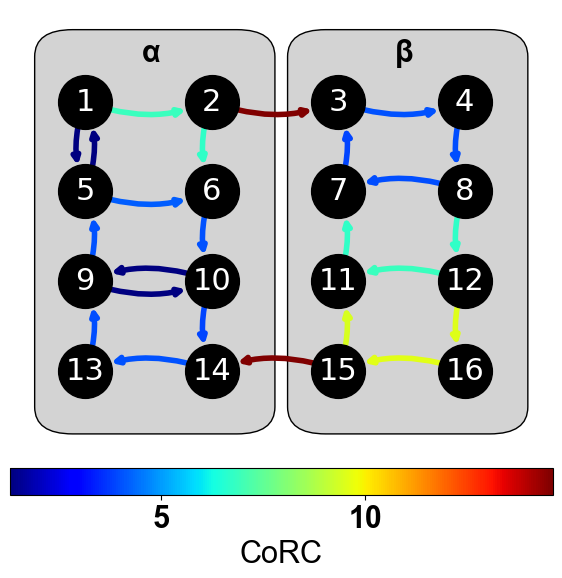

In [33]:
pos = {x:((x-1)%4,-int((x-1)/4)) for x in graph.nodes()}

colors = df["Cost"]
vmin = min(colors)
vmax = max(colors)

cmap=plt.cm.jet
plt.figure(figsize=(7,7))
options = {
    "node_color": 'k',
    "edge_color": colors,
    "node_size": 1500,
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": vmin,
    "edge_vmax": vmax,
    "with_labels": True,
    'font_color': "w",
    'font_size': '22',
}


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation='horizontal', label = "CoRC", pad = 0.025)
rectangle = matplotlib.patches.FancyBboxPatch((-0.1,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
plt.gca().add_patch(rectangle)

rectangle = matplotlib.patches.FancyBboxPatch((-0.1+2,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
plt.gca().add_patch(rectangle)

plt.annotate(r"α", (0.45, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)
plt.annotate(r"β", (0.45+2, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)

nx.draw(graph, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)

# plt.gca().set_facecolor("w")
plt.savefig("Results/Paper/small_grid_CoRC.pdf")
plt.show()

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


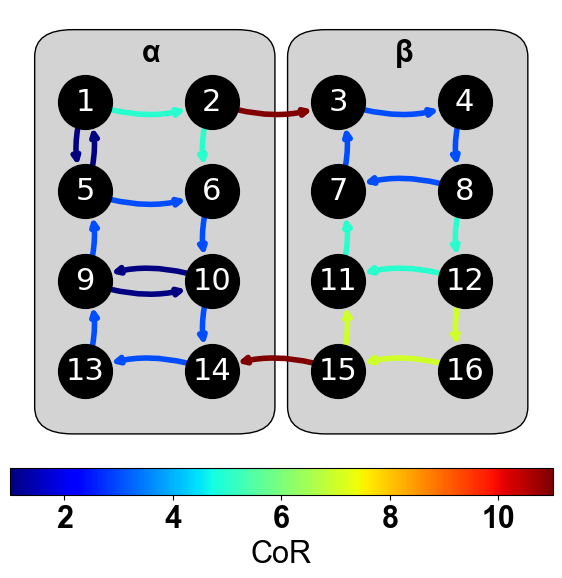

In [34]:
colors = df["SP_inverse"]
vmin = min(colors)
vmax = max(colors)

cmap=plt.cm.jet
plt.figure(figsize=(7,7))
options = {
    "node_color": 'k',
    "edge_color": colors,
    "node_size": 1500,
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": vmin,
    "edge_vmax": vmax,
    "with_labels": True,
    'font_color': "w",
    'font_size': '22',
}


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation='horizontal', label = "CoR", pad = 0.025)
rectangle = matplotlib.patches.FancyBboxPatch((-0.1,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
plt.gca().add_patch(rectangle)

rectangle = matplotlib.patches.FancyBboxPatch((-0.1+2,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
plt.gca().add_patch(rectangle)

plt.annotate(r"α", (0.45, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)
plt.annotate(r"β", (0.45+2, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)

nx.draw(graph, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)

# plt.gca().set_facecolor("w")
plt.savefig("Results/Paper/small_grid_CoR.pdf")
plt.show()

In [35]:
ii = 0
total_wccs = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topcor = df.sort_values(by = "Cost", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topcor)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs.append(max(wccs)/graph.number_of_nodes())

In [36]:
ii = 0
total_wccs_SP = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topSP = df.sort_values(by = "SP_inverse", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topSP)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs_SP.append(max(wccs)/graph.number_of_nodes())

In [37]:
total_wccs_bet = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topbet = df.sort_values(by = "Betweenness", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topbet)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs_bet.append(max(wccs)/graph.number_of_nodes())

## Plot

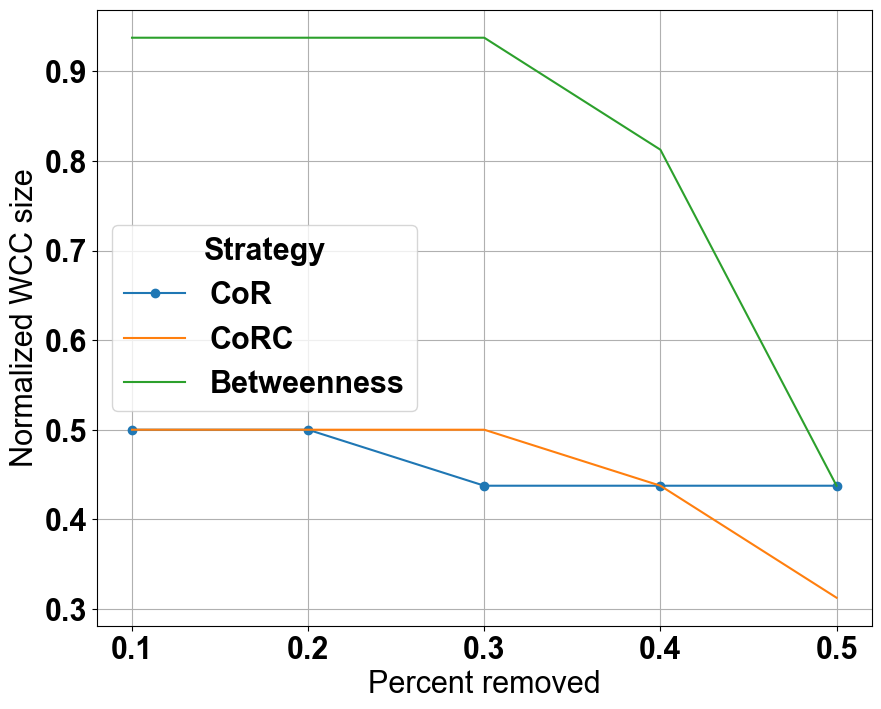

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(10,8))
plt.plot(percents, total_wccs_SP, '-o', label = "CoR")
plt.plot(percents, total_wccs, label = "CoRC")
plt.plot(percents, total_wccs_bet, label = "Betweenness")
# plt.plot(percents, sizes, label = "Exhaustive")
plt.ylabel("Normalized WCC size")
plt.xlabel("Percent removed")
plt.grid()
plt.legend(title= "Strategy")
plt.show()
plt.savefig("Results/Paper/small_grid_wccs.pdf")

# Small grid 2

In [13]:
edgelist = [[1, 2], 
[3, 4],
[4, 8],
[2, 3],
[8, 12],
[12, 16],
[14, 13],
[9, 5], 
[5, 1],
[6, 10],
[16, 15],
[15, 14],
[10, 11],
[11, 7],
[7, 6],
[12, 11],
[10, 9],
[13, 9],
[1, 5],
[5, 6],
[9, 10],
[14, 10],
[15, 11],
[8, 7],
[3, 7],
[2, 6],
]

G = nx.from_edgelist(edgelist, create_using = nx.DiGraph)
graph = nx.DiGraph()
graph.add_nodes_from(sorted(G.nodes(data=True)))
graph.add_edges_from(G.edges(data=True))

## Exhaustive test

In [14]:
dfs_wcc = []
all_wccs_exhaustive = []
total_wccs = []
dict_result = []
max_wcc = 1
ii=0

for j in tqdm(percents, position=1):
    for i in tqdm(it.combinations(list(graph.edges), int(graph.number_of_edges()*j)), position = 0):
        H = nx.DiGraph.copy(graph)
        H.remove_edges_from(i)
        wccs = []
        for k in nx.weakly_connected_components(H):
            wccs.append(len(k))
        size_wccs = (max(wccs)/graph.number_of_nodes())
        if max_wcc >= size_wccs:
            best_edges = i
            max_wcc = size_wccs
    dict_result.append({"Edges": best_edges, "Wcc size": max_wcc})
    

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
sizes = []
for i in dict_result:
    sizes.append(i["Wcc size"])

## Metrics

C:\Users\gio-x\AppData\Local\Temp\ipykernel_20688\3304533733.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cd[i][j] =np.sqrt(comm[i][i] + comm[j][j] - 2*comm[i][j])
C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python

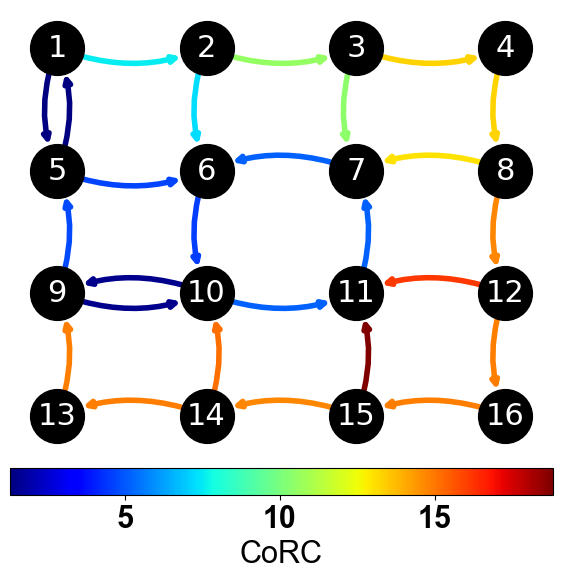

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


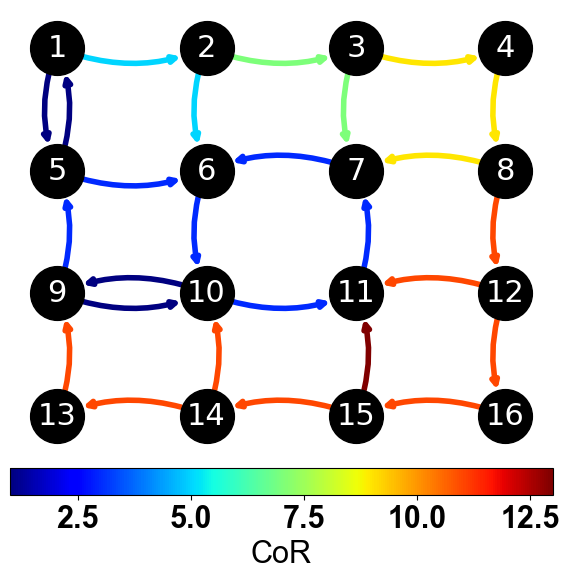

In [19]:
df, _ = calculations(graph)
pos = {x:((x-1)%4,-int((x-1)/4)) for x in graph.nodes()}

colors = df["Cost"]
vmin = min(colors)
vmax = max(colors)

cmap=plt.cm.jet
plt.figure(figsize=(7,7))
options = {
    "node_color": 'k',
    "edge_color": colors,
    "node_size": 1500,
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": vmin,
    "edge_vmax": vmax,
    "with_labels": True,
    'font_color': "w",
    'font_size': '22',
}


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation='horizontal', label = "CoRC", pad = 0.025)
# rectangle = matplotlib.patches.FancyBboxPatch((-0.1,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
# plt.gca().add_patch(rectangle)

# rectangle = matplotlib.patches.FancyBboxPatch((-0.1+2,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
# plt.gca().add_patch(rectangle)

# plt.annotate(r"α", (0.45, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)
# plt.annotate(r"β", (0.45+2, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)

nx.draw(graph, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)

# plt.gca().set_facecolor("w")
plt.savefig("Results/Paper/small_grid2_CoRC.pdf")
plt.show()
colors = df["SP_inverse"]
vmin = min(colors)
vmax = max(colors)

cmap=plt.cm.jet
plt.figure(figsize=(7,7))
options = {
    "node_color": 'k',
    "edge_color": colors,
    "node_size": 1500,
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": vmin,
    "edge_vmax": vmax,
    "with_labels": True,
    'font_color': "w",
    'font_size': '22',
}


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation='horizontal', label = "CoR", pad = 0.025)
# rectangle = matplotlib.patches.FancyBboxPatch((-0.1,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
# plt.gca().add_patch(rectangle)

# rectangle = matplotlib.patches.FancyBboxPatch((-0.1+2,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
# plt.gca().add_patch(rectangle)

# plt.annotate(r"α", (0.45, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)
# plt.annotate(r"β", (0.45+2, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)

nx.draw(graph, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)

# plt.gca().set_facecolor("w")
plt.savefig("Results/Paper/small_grid2_CoR.pdf")
plt.show()
ii = 0
total_wccs = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topcor = df.sort_values(by = "Cost", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topcor)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs.append(max(wccs)/graph.number_of_nodes())
ii = 0
total_wccs_SP = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topSP = df.sort_values(by = "SP_inverse", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topSP)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs_SP.append(max(wccs)/graph.number_of_nodes())
total_wccs_bet = []
for j in percents:
    remove = int(j*graph.number_of_edges())
    topbet = df.sort_values(by = "Betweenness", ascending = False).head(remove).index
    H = nx.DiGraph.copy(graph)
    H.remove_edges_from(topbet)
    wccs = []
    for i in nx.weakly_connected_components(H):
        wccs.append(len(i))
    total_wccs_bet.append(max(wccs)/graph.number_of_nodes())

## Plot

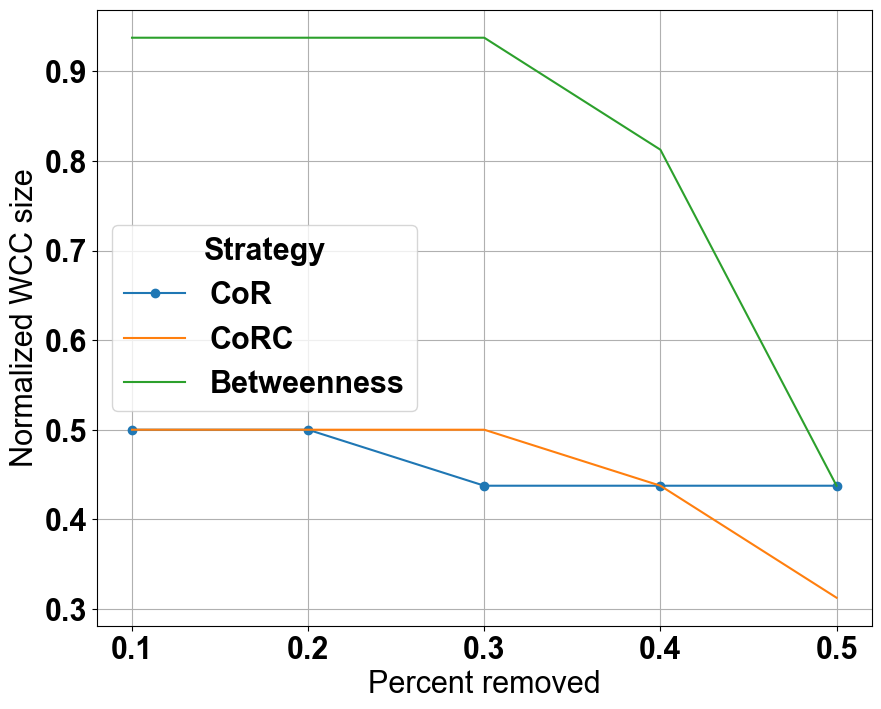

<Figure size 640x480 with 0 Axes>

In [39]:
plt.figure(figsize=(10,8))
plt.plot(percents, total_wccs_SP, '-o', label = "CoR")
plt.plot(percents, total_wccs, label = "CoRC")
plt.plot(percents, total_wccs_bet, label = "Betweenness")
# plt.plot(percents, sizes, label = "Exhaustive")
plt.ylabel("Normalized WCC size")
plt.xlabel("Percent removed")
plt.grid()
plt.legend(title= "Strategy")
plt.show()
plt.savefig("Results/Paper/small_grid2_wccs.pdf")